## Introduction

A/B tests are very commonly performed by data analysts and data scientists. 
A/B testing is a method of comparing two versions of a product or service (A and B) to determine which one performs better. A/B tests are commonly used in marketing and product development to determine which version of a product or marketing message is more effective. In an A/B test, a sample of users is shown one version of the product (A), while a separate sample of users is shown the other version (B). The results of the test are then used to determine which version performed better. A/B testing is a powerful tool because it allows companies to make data-driven decisions about their products and marketing strategies, rather than relying on guesswork or intuition.

There are many different statistical tests that can be used in A/B testing, and the appropriate test to use will depend on the specific details of the experiment. Some factors that can affect the choice of statistical test include the type of data being collected, the number of samples being tested, and the type of comparison being made.
<ol>
<li>If the data being collected is numerical (such as the number of clicks on a button or the time it takes to complete a task), then a statistical test such as a t-test or ANOVA may be appropriate.</li>
<li>If the data being collected is categorical (such as the number of users who click on a button or the number of users who complete a task), then a statistical test such as a chi-squared test or a z-test may be appropriate.</li>
<li>If the number of samples being tested is small, then a non-parametric test such as a Wilcoxon signed-rank test or a Mann-Whitney U test may be appropriate.</li>
<li>If the comparison being made is between two groups, then a two-sample test such as a t-test or a z-test may be appropriate.</li>
<li>If the comparison being made is between multiple groups, then a multi-sample test such as ANOVA or Kruskal-Wallis may be appropriate.</li>
</ol>

In this project, I will be conducting A/B tests on an e-commerce website. The website had launched a new page, and it is important to determine if the company should implement the new page, keep the old page, or change the parameters of the experiment.

## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"./ab_test_data.csv")
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
#Lets change the column headings for simplicity
df.columns = ['user_id', 'timestamp', 'group', 'landing_page', 'converted']
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
#What is the datatypes for the different columns
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [5]:
#Lets investigate if there are any missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(10)


,Total,Percent
user_id,0,0.0
timestamp,0,0.0
group,0,0.0
landing_page,0,0.0
converted,0,0.0


In [6]:
#How many rows and columns are there
df.shape

(294478, 5)

In [7]:
#how many unique values are there in each columns
df.nunique()

user_id         290584
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

There is a mismatch between the number of users assigned, it seems that there are duplicates in this group. This can be found as there are 294478 rows, and there should have been the same number of unique user_ids, however there are 290584 users.

In [8]:
#Lets investigate if there is a mismatch in the data
df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


In [9]:
mismatch = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page') | 
           (df['group'] == 'control') & (df['landing_page'] == 'new_page')]
mismatch

,user_id,timestamp,group,landing_page,converted
22,767017,58:15.0,control,new_page,0
240,733976,11:16.4,control,new_page,0
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
...,...,...,...,...,...
294014,813406,25:33.2,treatment,old_page,0
294200,928506,32:10.5,control,new_page,0
294252,892498,11:10.5,treatment,old_page,0
294253,886135,49:20.5,control,new_page,0


In [10]:
n_mismatch = mismatch.shape[0]

percent_mismatch = round(len(mismatch)/len(df) * 100,2)
print(f'Number of mismatched rows: {n_mismatch}')
print(f'Percentage of mismatch within the dataset: {percent_mismatch} percent')

Number of mismatched rows: 3893
Percentage of mismatch within the dataset: 1.32 percent


Given that there are 3893 mismatched user_ids which account to 1.32% of the dataset itself, these values should be excluded 

In [11]:
df2 = df[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | 
           (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
df2

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0


In [12]:
#lets investigate for any duplicates
duplicates = df2[df2.user_id.duplicated() == True]
duplicates

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [13]:
df2 = df2.drop_duplicates('user_id')

In [14]:
len(df2) - df2.user_id.nunique()

0

## Probability

In [15]:
#Percentage of convergence - the probability of an individual converting
round(df.converted.mean()*100,2)

11.97

In [16]:
#Given that an individual was in the control group, what is the probability they converted?
#Given that an individual was in the treatment group, what is the probability they converted?
round(df2.groupby('group').mean()*100,2)

,user_id,converted
group,,
control,78816407.26,12.04
treatment,78784571.93,11.88


In [17]:
#What is the probability that an individual received the new page?
round(pd.DataFrame(df2.landing_page.value_counts(normalize = True)*100),2)

,landing_page
new_page,50.01
old_page,49.99


<b>Is there a sufficient evidence to conclude that the new treatment page leads to more conversions? </b> <br>
<ol>
<li>The probability that an individual received the new page is 50%<br></li>
<li>The probability of an individual converting regardless of the page they receive is 11.96%<br></li>
<li>Given that an individual was in the control group, the probability they converted is 12.04%<br></li>
<li>Given that an individual was in the treatment group, the probability they converted is 11.88%<br></li>
</ol>
1 to 4 suggests that there is no significant difference in convergence between treatment and control groups. Therefore we may conclude that the new treatment page has no impact and does not lead to more conversions.

## A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%
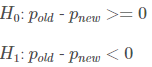

In [18]:
means_diff = []

size = df2.shape[0]
size

290584

In [19]:
#Creating the sampling distribution of difference in means
means_diff = []

size = 10000

for _ in range(10000):
    sample = df2.sample(size, replace = True)
    control_mean = sample[sample['group'] == 'control']['converted'].mean()
    treat_mean = sample[sample['group'] == 'treatment']['converted'].mean()
    means_diff.append(treat_mean - control_mean)

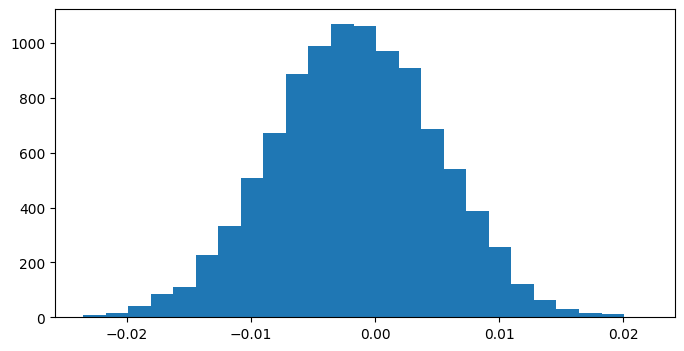

In [20]:
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [26]:
# simulate the distribution under the null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

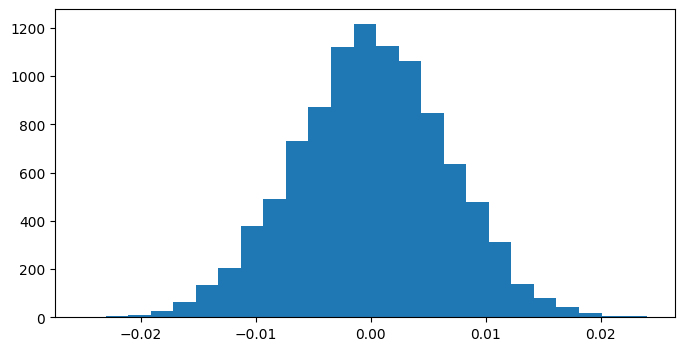

In [27]:
# Plot the null distribution
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

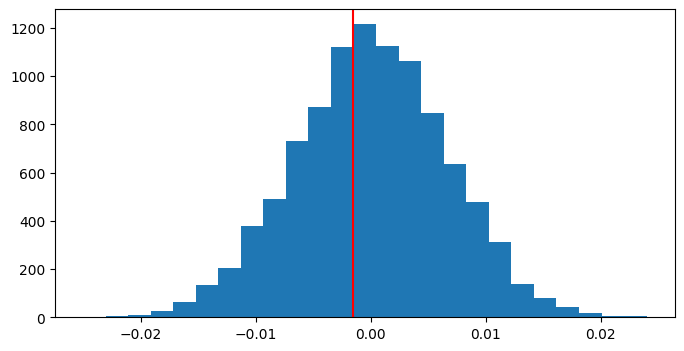

In [28]:
# Plot observed statistic with the null distibution
control_mean = df2[df2["group"] == "control"]["converted"].mean()
treat_mean = df2[df2["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c='red')
plt.show()

In [29]:
# calculating the p value 
(null_vals > obs_diff).mean()

0.6025

<b>Concluding remarks for this section so far:</b> <br>
<ol>
    <li>The p_value (0.6025) is greater than alpha, therefore we fail to reject the null.</li>
<li>This emphasizes of initial conclusion that there is no significant impact for the new page.</li>
</ol>
We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [73]:
import statsmodels.api as sm

convert_old = df2[(df2['converted'] == 1) & (df2['landing_page'] == 'old_page')]['user_id'].nunique()
convert_new = df2[(df2['converted'] == 1) & (df2['landing_page'] == 'new_page')]['user_id'].nunique()

n_old = df2[df2['landing_page'] == 'old_page']['user_id'].nunique()
n_new = df2[df2['landing_page'] == 'new_page']['user_id'].nunique()

In [74]:
#Lets compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [75]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

Using test statistic and p-value, we reach the same coclusion: we can not reject the null